In [842]:
from importlib.metadata import version
import nltk
import torch
import summa
import pandas as pd
import numpy as np


In [843]:
import urllib.request
# urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [844]:
data.sample(10)

,headlines,text
84971,"Priyanka beats 'Wonder Woman', ranks 1st on To...","Actress Priyanka Chopra, while beating Dwayne ..."
8543,We went wrong: Aamir takes full responsibility...,Actor Aamir Khan has taken the full responsibi...
23194,Separate north K'taka not happening during my ...,Slamming BJP leader BS Yeddyurappa for alleged...
39454,Indian football team's remaining matches also ...,All the tickets for the Indian football team's...
96095,J&K MLA detained while trying to march toward ...,Independent MLA Sheikh Abdul Rashid was detain...
70055,"$3.9-bn spacecraft crashes into Saturn, ends 2...",NASA's Cassini spacecraft plunged into Saturn'...
91323,Dying woman hands out candies with special mes...,"Karen French, who has stage IV lung cancer, di..."
54711,Sri Lankan courts order release of 69 Indian f...,Courts in Sri Lanka's Jaffna and Vavuniya have...
4719,Indian agency seeks US help in probing IndiGo ...,India's aircraft accident probe agency AAIB ha...
55424,UP CM proposes law to quash 20k politically mo...,Uttar Pradesh CM Yogi Adityanath on Thursday i...


In [845]:
'''
채점 루브릭
=========================================================================
=========================================================================

Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.

분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.

------------------------------------------------------------------
텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.

모델 학습이 진행되면서 train loss와 validation loss가 감소하는 경향을 그래프를 통해 확인했으며, 
실제 요약문에 있는 핵심 단어들이 요약 문장 안에 포함되었다.

-------------------------------------------------------------------

Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.

두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교하고 분석 결과를 표로 정리하여 제시하였다.

=========================================================================
=========================================================================



단계 1-5
=========================================================================
=========================================================================

Step 1. 데이터 수집하기
데이터는 아래 링크에 있는 뉴스 기사 데이터(news_summary_more.csv)를 사용하세요.

---------------------------------------------------------------------------

Step 2. 데이터 전처리하기 (추상적 요약)
실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 
전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 
만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 
불용어를 제거하는 것이 좋을지 고민해 보세요.

---------------------------------------------------------------------------

Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 
실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

---------------------------------------------------------------------------

Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보세요.

---------------------------------------------------------------------------

Step 5. Summa을 이용해서 추출적 요약해보기

=========================================================================
=========================================================================

'''
pass

In [846]:
'''
미리 선언된 정규화 사전을 사용하는게 맞을지 아니면,
다른 방법이 있을지?

BeautifulSoup(..., "lxml")은 없어도 될거 같고..
stopwords.words('english')는 왜 함수 안에 들어가서 호출을 매번하지?

정규화 사전은 “도메인 특화 표기 변형/오타/축약어”를 통일할 때 유용.
>>> 내가 다루는 데이터가 표기 변형/오타/축약어가 많은가?
>>  Hindu, Indian Times, Guardian의 뉴스 기사 스크랩

데이터에 대한 정보가 필요함

인도식 수 표현? 통화 기호? 
State Bank of India (SBI) 
Aam Aadmi Party (AAP)

뒤에 ()가 오는지 안오는지, Aam Aadmi Party 같은 긴 이름을 정규화

US EU 같은 약어 축어

"Lakmé", "Mo ët"
"a?��"  <<< 이거 같은 깨진 단어

"million":1e6,"billion":1e9,"trillion":1e12,"m":1e6,"bn":1e9,"b":1e9,"tn":1e12,"t":1e12,
"lakh":1e5,"lakhs":1e5,"crore":1e7,"crores":1e7

을 지수표현으로 치환

숫자 표현을 살리는 money 모드

'''
print('전체 샘플수 :', (len(data)))
print(data.isnull().sum())

전체 샘플수 : 98401
headlines    0
text         0
dtype: int64


In [847]:
import re
'''
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}
'''
SCALES = {
    "million":1e6,"billion":1e9,"trillion":1e12,"m":1e6,"bn":1e9,"b":1e9,"tn":1e12,"t":1e12,
    "lakh":1e5,"lakhs":1e5,"crore":1e7,"crores":1e7
}

try:
    from nltk.corpus import stopwords
    try:
        STOP_EN = set(stopwords.words('english'))
    except LookupError:
        import nltk
        nltk.download('stopwords')
        from nltk.corpus import stopwords
        STOP_EN = set(stopwords.words('english'))
except Exception:
    STOP_EN = set()

# 통화·스케일 정규화에서 계산된 숫자값을 문자열로 깔끔하게 변환하는 보조 함수
def _fmt_val(x: float) -> str:
    return str(int(x)) if float(x).is_integer() else str(x)

'''
def normalize_currency_and_scales

패턴 매칭 결과 활용
정규식에서 캡처한 그룹(num, dec, scale)을 꺼내서:

num: 정수 부분(콤마 제거)
dec: 소수 부분(없으면 빈 문자열)
scale: million, billion, m, bn 등 규모 단어(없을 수도 있음)

숫자값 계산

f"{num}.{dec}" if dec else num → '1500000' 또는 '1.5' 같은 문자열을 만들고 float(...)로 변환.
SCALES.get(scale, 1.0) → 규모 단어를 배율로 바꿔 곱함(million → 1e6, bn → 1e9, 없으면 1).
곱한 결과 val은 실제 금액(예: US$ 1.5 billion → 1500000000.0).
mode에 따른 출력

mode == "value"이면 계산값을 붙여 usd 1500000000 같은 문자열을 돌려줍니다(_fmt_val로 불필요한 .0 제거).
그렇지 않으면 단순히 " usd "만 반환해, 모든 달러 표현을 동일 토큰으로 축약.

'''
def normalize_currency_and_scales(s: str, mode: str = "token") -> str:
    # mode: "token" → 의미 토큰만 남김, "value" → 기준 단위 수치로 확장(USD/INR/AMOUNT + 값)
    def sub_usd(m):
        num = m.group("num").replace(",", "")
        dec = m.group("dec") or ""
        scale = (m.group("scale") or "").lower()
        val = float(f"{num}.{dec}" if dec else num) * SCALES.get(scale, 1.0)
        if mode == "value":
            return f" usd {_fmt_val(val)} "
        return " usd "



    def sub_inr(m): #  INR 표기(₹, Rs, INR, rupees) 토큰으로 바꾸거나, 숫자로 치환하거나
        num = (m.group("num") or "").replace(",", "")
        dec = m.group("dec") or ""
        scale = (m.group("scale") or "").lower()
        if not num:
            return m.group(0)
        val = float(f"{num}.{dec}" if dec else num) * SCALES.get(scale, 1.0)
        if mode == "value":
            return f" inr {_fmt_val(val)} "
        return " inr "

    # USD: $ / US$ + 숫자 [+ 스케일]
    usd_pat = re.compile(
        r"(?<!\w)US?\$\s*(?P<num>\d{1,3}(?:,\d{3})*|\d+)(?:\.(?P<dec>\d+))?\s*(?P<scale>million|billion|trillion|m|bn|b|tn|t)?",
        re.I
    )
    s = usd_pat.sub(sub_usd, s)

    # INR: ₹ 또는 Rs./INR/rupee + 숫자 [+ 스케일]
    inr_symbol_pat = re.compile(
        r"(?:₹)\s*(?P<num>\d{1,3}(?:,\d{2,3})*|\d+)(?:\.(?P<dec>\d+))?\s*(?P<scale>lakh|lakhs|crore|crores|million|billion|trillion|m|bn|b|tn|t)?",
        re.I
    )
    s = inr_symbol_pat.sub(sub_inr, s)

    inr_word_pat = re.compile(
        r"\b(?:Rs\.?|INR|rupees?)\s*(?P<num>\d{1,3}(?:,\d{2,3})*|\d+)(?:\.(?P<dec>\d+))?\s*(?P<scale>lakh|lakhs|crore|crores|million|billion|trillion|m|bn|b|tn|t)?",
        re.I
    )
    s = inr_word_pat.sub(sub_inr, s)

    # 통화 미지정 스케일: 5 lakh / 1.5 billion 등
    def sub_amount(m):
        val = float(m.group("num")) * SCALES.get(m.group("scale").lower(), 1.0)
        if mode == "value":
            return f" amount {_fmt_val(val)} "
        return " amount "

    bare_scale_pat = re.compile(
        r"\b(?P<num>\d+(?:\.\d+)?)\s*(?P<scale>lakh|lakhs|crore|crores|million|billion|trillion|m|bn|b|tn|t)\+?\b",
        re.I
    )
    s = bare_scale_pat.sub(sub_amount, s)
    return s

def preprocess_sentence_hardcoded(sentence: str, remove_stopwords: bool = True, money_mode: str = "token") -> str:
    s = (sentence or "").lower()

    # 1) 매우 단순 HTML 제거
    # s = re.sub(r"<[^>]+>", " ", s)

    # 2) 스마트 따옴표/대시 간단 통일
    s = s.replace("’","'").replace("‘","'").replace("“","\"").replace("”","\"").replace("–","-").replace("—","-")

    # 3) 긴이름 (ACR) → acr 로 치환(약어 보존)
    s = re.sub(
        r"\b([a-z][a-z]+(?:[-\s](?:[a-z][a-z]+|of|and|for|the|&)){1,})\s*\(\s*([A-Z]{2,})\s*\)",
        lambda m: " " + m.group(2).lower() + " ",
        s,
        flags=re.I
    )

    # 4) 괄호 안 내용 제거(베이스라인 규칙 유지)
    s = re.sub(r"\([^)]*\)", " ", s)

    # 5) 쌍따옴표 제거
    s = s.replace('"', " ")

    # 6) 약어(contractions) 확장
    # s = " ".join(contractions.get(tok, tok) for tok in s.split())

    # 7) 소유격 's 제거
    s = re.sub(r"'s\b", "", s)

    # 8) 통화/스케일 정규화(여기서 숫자 변환/토큰화 처리)
    s = normalize_currency_and_scales(s, mode=money_mode)

    # 9) m 반복 축약
    s = re.sub(r"[m]{3,}", "mm", s)

    # 10) 문자 필터: token 모드→숫자 제거 유지, value 모드→숫자 보존
    if money_mode == "value":
        s = re.sub(r"[^a-z0-9]", " ", s)
    else:
        s = re.sub(r"[^a-z]", " ", s)

    # 11) 불용어 제거 및 최소 길이 필터
    words = [w for w in s.split() if len(w) > 1]
    try:
        USE_STOP = (len(STOP_EN) > 0) and remove_stopwords
    except NameError:
        USE_STOP = False
    if USE_STOP:
        words = [w for w in words if w not in STOP_EN]

    return " ".join(words)
# STOP_EN <<< 미리로드한 불용어 집합
# remove_stopwords 가 True 일때만, 작동

In [848]:
# 샘플 테스트
temp_text = ['Aam Aadmi Party (AAP) wins Delhi polls.',' Bharatiya Janata Party (BJP) proposes Rs. 2.5 crore plan.','US$ 1.5 billion pledged to infra.',
             '₹ 25,000 crore debt reduced; Rs 75 lakh subsidy announced.','We’re sure it’s BJP’s plan and they can’t deny.','Ummmm—really—long-term budget',
             ' U.S. and U.K. officials met; US$3m approved.',' India-Pakistan ties improve after 2 bn trade deal.']

for i in temp_text:
    print("text: ", preprocess_sentence_hardcoded(i))

for j in temp_text:
    print("text:", preprocess_sentence_hardcoded(j,remove_stopwords=True,money_mode="value"))

'''
숫자에 대해, 
US$3m = usd 3000000
₹ 25,000 crore = inr 250 000000000
'''

text:  aap wins delhi polls
text:  bjp proposes inr plan
text:  usd pledged infra
text:  inr debt reduced inr subsidy announced
text:  sure bjp plan deny
text:  umm really long term budget
text:  officials met usd approved
text:  india pakistan ties improve amount trade deal
text: aap wins delhi polls
text: bjp proposes inr 25000000 plan
text: usd 1500000000 pledged infra
text: inr 250 000000000 debt reduced inr 7500000 subsidy announced
text: sure bjp plan deny
text: umm really long term budget
text: officials met usd 3000000 approved
text: india pakistan ties improve amount 2000000000 trade deal


'\n숫자에 대해, \nUS$3m = usd 3000000\n₹ 25,000 crore = inr 250 000000000\n'

In [849]:
# 전체 Text 데이터에 대한 전처리 : 15초정도 걸립니다.
clean_text = []

for sentence in data['text']:
    clean_text.append(preprocess_sentence_hardcoded(sentence))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

clean_text_money = []

for sentence in data['text']:
    clean_text_money.append(preprocess_sentence_hardcoded(sentence,money_mode="value"))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text_money[:5])


'''
>>> 10분씩 걸린 이유
BeautifulSoup(..., "lxml") 호출
stopwords.words('english')도 매번 호출 
re.sub()
'''

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered amount careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options ins

'\n>>> 10분씩 걸린 이유\nBeautifulSoup(..., "lxml") 호출\nstopwords.words(\'english\')도 매번 호출 \nre.sub()\n'

In [850]:
clean_headlines	 = []

for sentence in data['headlines']:
    clean_headlines.append(preprocess_sentence_hardcoded(sentence,remove_stopwords=True))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

clean_headlines_money	 = []

for sentence in data['headlines']:
    clean_headlines_money.append(preprocess_sentence_hardcoded(sentence,remove_stopwords=True))

print("headlines 전처리 후 결과: ", clean_headlines_money[:5])

headlines 전처리 후 결과:  ['upgrad learner switches career ml al salary hike', 'delhi techie wins free food swiggy one year cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'known hirani yrs metoo claims true sonam']
headlines 전처리 후 결과:  ['upgrad learner switches career ml al salary hike', 'delhi techie wins free food swiggy one year cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'known hirani yrs metoo claims true sonam']


In [851]:
data['text'] = clean_text_money
data['headlines'] = clean_headlines_money

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [852]:
data.isnull().sum()
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 36.062336764870274
요약의 최소 길이 : 1
요약의 최대 길이 : 13
요약의 평균 길이 : 7.129703966423105


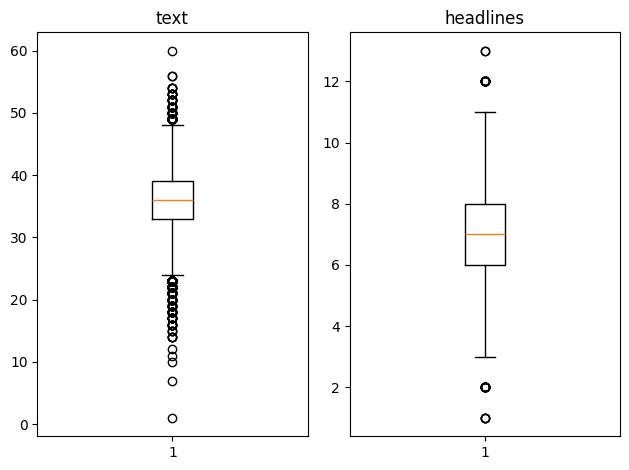

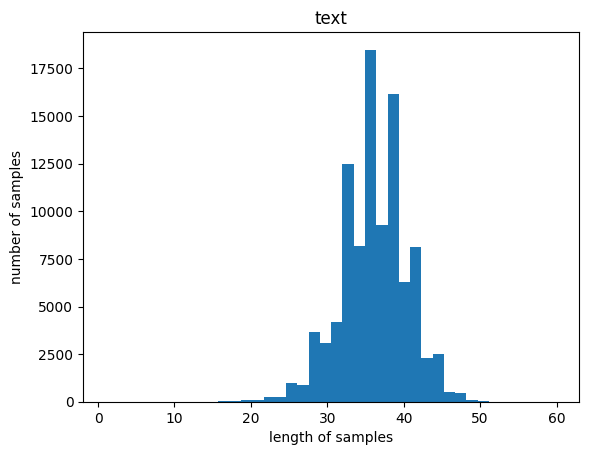

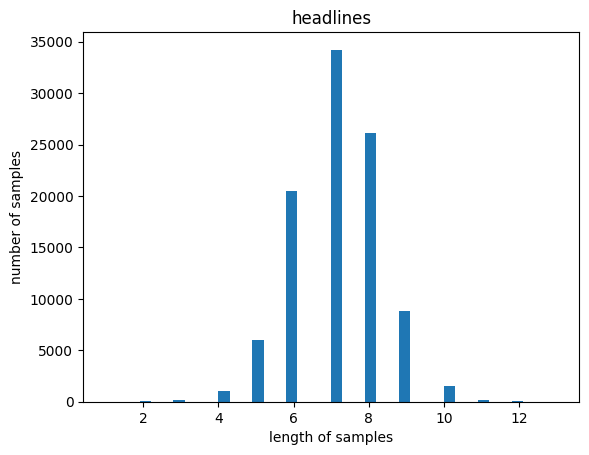

In [853]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [854]:
text_max_len = 50
summary_max_len = 10

In [855]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))


In [856]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(summary_max_len, data['headlines'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9994512250891759
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.9978658753467953


In [857]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= summary_max_len)]

print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98138


In [858]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches career ml al salary hike,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches career ml al ...,upgrad learner switches career ml al salary hi...
1,delhi techie wins free food swiggy one year cred,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food swiggy on...,delhi techie wins free food swiggy one year cr...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,known hirani yrs metoo claims true sonam,speaking sexual harassment allegations rajkuma...,sostoken known hirani yrs metoo claims true sonam,known hirani yrs metoo claims true sonam eostoken


In [859]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [860]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[15386 72979 24159 ... 79239   272 66520]


In [861]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [862]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19627


In [863]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78511
훈련 레이블의 개수 : 78511
테스트 데이터의 개수 : 19627
테스트 레이블의 개수 : 19627


In [864]:
from collections import Counter

def src_tokenizer(text): # 토크나이저 정의
    text = text.lower()  # 소문자로 변환
    text = re.sub(r"[^a-zA-Z0-9]+", " ", text)  # 특수문자 제거
    return text.split()  # 공백 기준 토큰화

def build_vocab(texts):
    vocab = {"<PAD>": 0, "<UNK>": 1}  # 패딩과 UNK 토큰 추가
    word_counter = Counter()

    for text in texts:
        word_counter.update(src_tokenizer(text))  # 단어 빈도수 계산

    # 단어 집합 생성 (빈도가 높은 순서대로)
    for word, _ in word_counter.most_common():
        if word not in vocab:
            vocab[word] = len(vocab)

    return vocab

src_vocab = build_vocab(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [865]:
threshold = 7

# 전처리된 데이터 사용
text_data = data['text'].tolist()
summary_data = data['headlines'].tolist()
# 단어 빈도수 계산
word_counter = Counter()
for text in text_data:
    word_counter.update(text.split())

total_cnt = len(word_counter)  # 전체 단어 개수
total_freq = sum(word_counter.values())  # 전체 단어 등장 횟수
rare_cnt = sum(1 for count in word_counter.values() if count < threshold)  # 희귀 단어 개수
rare_freq = sum(count for count in word_counter.values() if count < threshold)  # 희귀 단어 등장 횟수

# 희귀 단어를 제외한 단어 사전 구축
vocab = {"<PAD>": 0, "<UNK>": 1}  # 패딩 및 미등록 단어 추가
word_index = {word: idx + 2 for idx, (word, count) in enumerate(word_counter.items()) if count >= threshold}

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 81913
등장 빈도가 6번 이하인 희귀 단어의 수: 56128
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 25785
단어 집합에서 희귀 단어의 비율: 68.52148010694273
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.200593418627838


In [866]:
src_vocab_size = 50000

def build_limited_vocab(texts, vocab_size):
    vocab = {"<PAD>": 0, "<UNK>": 1}  # 패딩과 UNK 토큰 추가
    word_counter = Counter()

    for text in texts:
        word_counter.update(src_tokenizer(text))  # 단어 빈도수 계산

    # 빈도가 높은 상위 vocab_size - 2개 단어만 선택 (PAD, UNK 포함)
    for word, _ in word_counter.most_common(vocab_size - 2):
        vocab[word] = len(vocab)

    return vocab

def build_limited_vocab_target(texts, vocab_size):
    vocab = {"<PAD>": 0, "<UNK>": 1, "sostoken": 2, "eostoken": 3}
    word_counter = Counter()
    for text in texts:
        word_counter.update(src_tokenizer(text))
    budget = max(0, vocab_size - len(vocab))
    for word, _ in word_counter.most_common(budget):
        if word not in vocab:
            vocab[word] = len(vocab)
    return vocab

src_vocab = build_limited_vocab(encoder_input_train, src_vocab_size)


In [867]:
def text_to_sequence(texts, vocab):
    sequences = []
    for text in texts:
        sequence = [vocab.get(word, vocab["<UNK>"]) for word in src_tokenizer(text)]
        sequences.append(sequence)
    return sequences

# 텍스트 데이터 정수 시퀀스로 변환
encoder_input_train_seq = text_to_sequence(encoder_input_train, src_vocab)
encoder_input_test_seq = text_to_sequence(encoder_input_test, src_vocab)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train_seq[:3])
print(encoder_input_test_seq[:3])

[[10799, 2746, 46, 17, 1244, 646, 1970, 1468, 2, 2713, 562, 3671, 412, 653, 1547, 4, 1635, 437, 13394, 21607, 7881, 46, 163, 260, 12267, 1082, 437, 222, 101, 3085, 3243, 1885, 8377], [724, 1438, 716, 47720, 716, 18199, 1579, 348, 36884, 422, 5308, 799, 560, 1659, 1874, 947, 25, 36884, 2412, 2412, 10355, 365, 294, 15900, 185, 648, 1179, 1381, 5094, 732, 1622, 207, 121, 1087, 321], [33, 565, 1218, 598, 157, 17, 115, 48, 2, 598, 283, 4, 11356, 5, 797, 16569, 17339, 3362, 598, 2090, 3307, 3283, 4, 3800, 3008, 4428, 5051, 598, 4047, 1253, 8140, 5]]
[[176, 21, 2436, 3146, 5017, 3989, 3167, 62, 2, 2765, 21, 1944, 3288, 6361, 7267, 1647, 5746, 16253, 4616, 1647, 12, 2233, 2582, 2257, 304, 1238, 22, 2321, 2436, 1573, 2644, 1068, 1647, 3238, 2436], [407, 14, 1135, 96, 460, 1836, 37, 622, 17, 3649, 2445, 59, 2, 2788, 463, 222, 2018, 4, 2082, 202, 23, 52, 115, 48, 273, 343, 39, 2, 712, 2788, 463, 506, 100, 3947, 10], [217, 1222, 87, 6245, 4335, 568, 109, 3495, 15, 4274, 6042, 716, 49603, 1047, 1, 

In [868]:
def tar_tokenizer(text):
    text = text.lower()  # 소문자로 변환
    text = re.sub(r"[^a-zA-Z0-9]+", " ", text)  # 특수문자 제거
    return text.split()  # 공백 기준 토큰화

tar_vocab = build_vocab(decoder_input_train)

In [869]:
threshold = 6

word_counter = Counter()
for text in decoder_input_train:
    word_counter.update(tar_tokenizer(text))  # 각 문장의 단어 빈도 계산

# 전체 단어 개수 및 등장 빈도 계산
total_cnt = len(word_counter)  # 전체 단어 개수
total_freq = sum(word_counter.values())  # 전체 단어 등장 횟수
rare_cnt = sum(1 for count in word_counter.values() if count < threshold)  # 희귀 단어 개수
rare_freq = sum(count for count in word_counter.values() if count < threshold)  # 희귀 단어 등장 횟수

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29912
등장 빈도가 5번 이하인 희귀 단어의 수: 19661
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10251
단어 집합에서 희귀 단어의 비율: 65.7294731211554
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.905442045655914


In [870]:
TGT_MAX_VOCAB = 20000
tar_vocab = build_limited_vocab_target(decoder_input_train + decoder_target_train, TGT_MAX_VOCAB)
tar_vocab_size = len(tar_vocab)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train_seq = text_to_sequence(decoder_input_train, tar_vocab)
decoder_target_train_seq = text_to_sequence(decoder_target_train, tar_vocab)
decoder_input_test_seq = text_to_sequence(decoder_input_test, tar_vocab)
decoder_target_test_seq = text_to_sequence(decoder_target_test, tar_vocab)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train_seq[:5])
print('target')
print('decoder ',decoder_target_train_seq[:5])

input
input  [[2, 583, 7322, 366, 284, 2871, 4, 4313, 932], [2, 417, 811, 828, 6842, 454, 350], [2, 946, 4, 143, 3235, 36, 8, 363], [2, 53, 330, 5, 1245, 8919, 1898, 4485, 517, 389, 17], [2, 5719, 873, 392, 11017, 7047]]
target
decoder  [[583, 7322, 366, 284, 2871, 4, 4313, 932, 3], [417, 811, 828, 6842, 454, 350, 3], [946, 4, 143, 3235, 36, 8, 363, 3], [53, 330, 5, 1245, 8919, 1898, 4485, 517, 389, 17, 3], [5719, 873, 392, 11017, 7047, 3]]


In [871]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78511
훈련 레이블의 개수 : 78511
테스트 데이터의 개수 : 19627
테스트 레이블의 개수 : 19627


In [872]:
from torch.nn.utils.rnn import pad_sequence

# 텐서 변환 함수 (리스트 → PyTorch 텐서)
def convert_to_tensor(sequences):
    return [torch.tensor(seq, dtype=torch.long) for seq in sequences]

# 패딩 적용 함수 (PyTorch `pad_sequence()` 활용)
def pad_sequences_pytorch(sequences, maxlen, padding_value=0):
    sequences = convert_to_tensor(sequences)  # 리스트를 텐서로 변환
    padded_seqs = pad_sequence(sequences, batch_first=True, padding_value=padding_value)  # 패딩 적용
    return padded_seqs[:, :maxlen]  # maxlen 길이로 자르기 (최대 길이 초과 방지)

# 패딩 적용
encoder_input_train = pad_sequences_pytorch(encoder_input_train_seq, maxlen=text_max_len)
encoder_input_test = pad_sequences_pytorch(encoder_input_test_seq, maxlen=text_max_len)
decoder_input_train = pad_sequences_pytorch(decoder_input_train_seq, maxlen=summary_max_len)
decoder_target_train = pad_sequences_pytorch(decoder_target_train_seq, maxlen=summary_max_len)
decoder_input_test = pad_sequences_pytorch(decoder_input_test_seq, maxlen=summary_max_len)
decoder_target_test = pad_sequences_pytorch(decoder_target_test_seq, maxlen=summary_max_len)


In [873]:
import torch.nn as nn
import torch.nn.functional as F

# 인코더 설계 시작
embedding_dim = 256
hidden_size = 512
src_vocab_size = len(src_vocab)  # 단어 집합 크기

# 인코더
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers=3, dropout=0.2):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            embedding_dim, hidden_size, num_layers=num_layers,
            dropout=dropout, batch_first=True
        )

    def forward(self, x): # 인코더의 임베딩 층
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded)  # LSTM 실행
        return output, hidden, cell

# 인코더 모델 생성
encoder = Encoder(src_vocab_size, embedding_dim, hidden_size, num_layers=3, dropout=0.2)

In [874]:
# 디코더 설계
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, dropout=0.2, num_layers=3):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            embedding_dim, hidden_size, num_layers=num_layers, dropout=dropout,
            batch_first=True
        )

    def forward(self, x, hidden, cell): # 디코더의 임베딩 층
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))  # 초기 상태를 인코더에서 전달받음
        return output, hidden, cell

# 디코더 모델 생성
decoder = Decoder(tar_vocab_size, embedding_dim, hidden_size, num_layers=3, dropout=0.2)

In [875]:
# 디코더의 출력층
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, vocab_size):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.softmax_layer = nn.Linear(hidden_size, vocab_size)  # 출력층 정의

    def forward(self, encoder_input, decoder_input):
        # 인코더 실행
        encoder_output, hidden, cell = self.encoder(encoder_input)

        # 디코더 실행
        decoder_output, _, _ = self.decoder(decoder_input, hidden, cell)

        # 출력층 적용 (Softmax는 Loss 내부에서 적용되므로 생략 가능)
        output = self.softmax_layer(decoder_output)
        return output

# 모델 정의
model = Seq2Seq(encoder, decoder, tar_vocab_size)
print(model)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(50000, 256)
    (lstm): LSTM(256, 512, num_layers=3, batch_first=True, dropout=0.2)
  )
  (decoder): Decoder(
    (embedding): Embedding(19998, 256)
    (lstm): LSTM(256, 512, num_layers=3, batch_first=True, dropout=0.2)
  )
  (softmax_layer): Linear(in_features=512, out_features=19998, bias=True)
)


In [876]:
class Attention_dot(nn.Module):
    def __init__(self, hidden_size):
        super(Attention_dot, self).__init__()
        self.attn = nn.Linear(hidden_size, hidden_size)  # 어텐션 가중치
        self.v = nn.Linear(hidden_size, 1, bias=False)  # 어텐션 가중치 벡터

    def forward(self, decoder_output, encoder_outputs):
        attn_weights = torch.bmm(decoder_output, encoder_outputs.transpose(1, 2))
        attn_weights = F.softmax(attn_weights, dim=-1)  # 어텐션 가중치 정규화
        attn_out = torch.bmm(attn_weights, encoder_outputs)

        return attn_out

class Seq2SeqWithAttention(nn.Module):
    def __init__(self, encoder, decoder, vocab_size, hidden_size):
        super(Seq2SeqWithAttention, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.attention = Attention_dot(hidden_size)
        self.concat = nn.Linear(hidden_size * 2, hidden_size)  # 어텐션 결합
        self.output_layer = nn.Linear(hidden_size, vocab_size)  # 최종 출력층

    def forward(self, encoder_input, decoder_input):
        encoder_outputs, hidden, cell = self.encoder(encoder_input)
        decoder_outputs, _, _ = self.decoder(decoder_input, hidden, cell)

        # 어텐션 적용
        scores = torch.bmm(decoder_outputs, encoder_outputs.transpose(1, 2))  # [B, T_dec, T_enc]
        enc_mask = (encoder_input != 0)
        mask = enc_mask.unsqueeze(1).expand_as(scores)  # [B, T_dec, T_enc]
        scores = scores.masked_fill(~mask, -1e9)
        attn_weights = F.softmax(scores, dim=-1)
        attn_out = torch.bmm(attn_weights, encoder_outputs)

        # 어텐션 결과와 디코더 출력 연결
        decoder_concat_output = torch.cat((decoder_outputs, attn_out), dim=-1)

        # 어텐션 결합 후 최종 출력
        decoder_concat_output = torch.tanh(self.concat(decoder_concat_output))
        output = self.output_layer(decoder_concat_output)

        return output

# 모델 생성
model = Seq2SeqWithAttention(encoder, decoder, tar_vocab_size, hidden_size)
print(model)

Seq2SeqWithAttention(
  (encoder): Encoder(
    (embedding): Embedding(50000, 256)
    (lstm): LSTM(256, 512, num_layers=3, batch_first=True, dropout=0.2)
  )
  (decoder): Decoder(
    (embedding): Embedding(19998, 256)
    (lstm): LSTM(256, 512, num_layers=3, batch_first=True, dropout=0.2)
  )
  (attention): Attention_dot(
    (attn): Linear(in_features=512, out_features=512, bias=True)
    (v): Linear(in_features=512, out_features=1, bias=False)
  )
  (concat): Linear(in_features=1024, out_features=512, bias=True)
  (output_layer): Linear(in_features=512, out_features=19998, bias=True)
)


In [877]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
'''
왜 이상한 소리만 하는거니

어텐션이 패딩을 보지 않도록 마스크 적용했는데  1029/ 01:31


왜 이상한 소리만 하는거니

headlines 불용어도 안지우게 해줬잖아
타깃 Vocab도 2만으로 늘려줬잖아

나도 이제 한계다. 그냥 나가 틀려라 모델 탓 파라미터탓 하이퍼 파라미터 탓하지 마라. 
나도 충분히 기다려줬다. 
매 회차마다 저렇게 차이가 나면 하  1029 / 03:03

진짜 마지막 데코레이터 온몸비틀기
이거는 저도 이해 못하는 코드입니다.
이거 안돼면 자러감.

'''
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")
model.to(device)

@torch.no_grad()
def generate_greedy_no_repeat(model, encoder_input, sos_id, eos_id, max_len=30, no_repeat_ngram_size=3, min_len=3):
    model.eval()
    B = encoder_input.size(0)
    device = encoder_input.device
    enc_out, h, c = model.encoder(encoder_input)
    enc_mask = (encoder_input != 0)

    # initialize with SOS
    y = torch.full((B, 1), sos_id, dtype=torch.long, device=device)
    finished = torch.zeros(B, dtype=torch.bool, device=device)
    generated = [[] for _ in range(B)]

    def blocked_tokens(history, n):
        if n <= 1 or len(history) < n - 1:
            return set()
        table = {}
        for i in range(len(history) - n + 1):
            prefix = tuple(history[i : i + n - 1])
            nxt = history[i + n - 1]
            table.setdefault(prefix, set()).add(nxt)
        prefix = tuple(history[-(n - 1) :])
        return table.get(prefix, set())

    for t in range(max_len):
        dec_out, h, c = model.decoder(y, h, c)  # [B,1,H]
        scores = torch.bmm(dec_out, enc_out.transpose(1, 2))  # [B,1,T_enc]
        mask = enc_mask.unsqueeze(1).expand_as(scores)
        scores = scores.masked_fill(~mask, -1e9)
        attn = F.softmax(scores, dim=-1)
        ctx = torch.bmm(attn, enc_out).squeeze(1)  # [B,H]
        dec_step = dec_out.squeeze(1)              # [B,H]
        logits = model.output_layer(torch.tanh(model.concat(torch.cat([dec_step, ctx], dim=-1))))  # [B,V]

        # prevent early EOS before min_len
        if t < min_len:
            logits[:, eos_id] = -1e9

        # no-repeat n-gram blocking per sample
        if no_repeat_ngram_size and no_repeat_ngram_size > 1:
            for i in range(B):
                if finished[i]:
                    continue
                blk = blocked_tokens(generated[i], no_repeat_ngram_size)
                if blk:
                    logits[i, list(blk)] = -1e9

        next_tok = torch.argmax(logits, dim=-1)  # [B]
        # force EOS for already finished sequences
        next_tok = torch.where(finished, torch.full_like(next_tok, eos_id), next_tok)

        for i in range(B):
            if not finished[i]:
                generated[i].append(int(next_tok[i].item()))
                if next_tok[i].item() == eos_id:
                    finished[i] = True

        if finished.all():
            break
        y = next_tok.unsqueeze(1)

    return generated

# Beam search with no-repeat n-gram constraint
@torch.no_grad()
def generate_beam_no_repeat(
    model,
    encoder_input,
    sos_id,
    eos_id,
    *,
    beam_size: int = 4,
    max_len: int = 30,
    no_repeat_ngram_size: int = 3,
    length_penalty_alpha: float = 0.6,
    min_len: int = 1,
):
    """Beam search decoding (batch-wise, processes each sample independently).

    Returns: List[List[int]] of token ids per sample (excluding SOS; includes EOS if generated).
    """
    model.eval()

    def length_penalty(length):
        # Google NMT length penalty
        return ((5.0 + length) / 6.0) ** length_penalty_alpha

    def blocked_tokens(history, n):
        if n is None or n <= 1 or len(history) < n - 1:
            return set()
        table = {}
        for i in range(len(history) - n + 1):
            prefix = tuple(history[i : i + n - 1])
            nxt = history[i + n - 1]
            table.setdefault(prefix, set()).add(nxt)
        prefix = tuple(history[-(n - 1) :])
        return table.get(prefix, set())

    B = encoder_input.size(0)
    device = encoder_input.device
    results = []
    for b in range(B):
        src = encoder_input[b : b + 1]  # [1, T_enc]
        enc_out, h, c = model.encoder(src)
        enc_mask = (src != 0)

        # beam state: (logprob, tokens, last_token, h, c, ended)
        init = (0.0, [], sos_id, h, c, False)
        beams = [init]
        finished = []

        for t in range(max_len):
            new_beams = []
            for lp, toks, last_tok, h_i, c_i, endflag in beams:
                if endflag:
                    new_beams.append((lp, toks, last_tok, h_i, c_i, True))
                    continue
                # Prevent EOS before min_len
                forbid_eos = (t < min_len)

                y = torch.tensor([[last_tok]], dtype=torch.long, device=device)  # [1,1]
                dec_out, h_n, c_n = model.decoder(y, h_i, c_i)  # [1,1,H]
                scores = torch.bmm(dec_out, enc_out.transpose(1, 2))  # [1,1,T_enc]
                mask = enc_mask.unsqueeze(1).expand_as(scores)
                scores = scores.masked_fill(~mask, -1e9)
                attn = F.softmax(scores, dim=-1)
                ctx = torch.bmm(attn, enc_out).squeeze(1)  # [1,H]
                dec_step = dec_out.squeeze(1)              # [1,H]
                logits = model.output_layer(torch.tanh(model.concat(torch.cat([dec_step, ctx], dim=-1))))  # [1,V]
                log_probs = F.log_softmax(logits, dim=-1).squeeze(0)  # [V]

                # no-repeat n-gram blocking
                if no_repeat_ngram_size and no_repeat_ngram_size > 1:
                    blk = blocked_tokens(toks, no_repeat_ngram_size)
                    if blk:
                        log_probs[list(blk)] = -1e9
                if forbid_eos:
                    log_probs[eos_id] = -1e9

                topk_logp, topk_idx = torch.topk(log_probs, k=beam_size)
                for k in range(beam_size):
                    tid = int(topk_idx[k].item())
                    nlp = lp + float(topk_logp[k].item())
                    nend = (tid == eos_id)
                    new_beams.append((nlp, toks + [tid], tid, h_n, c_n, nend))

            # prune to beam_size with temporary length-normalized scores for stability
            def rank_key(bm):
                nlp, toks, _, _, _, ended = bm
                denom = length_penalty(len(toks))
                return nlp / max(1e-6, denom)

            new_beams.sort(key=rank_key, reverse=True)
            beams = new_beams[:beam_size]

            # collect finished
            finished.extend([bm for bm in beams if bm[5]])
            # early stop if enough finished beams
            if len(finished) >= beam_size:
                break

        pool = finished if finished else beams
        # final select with length penalty
        pool.sort(key=lambda bm: bm[0] / max(1e-6, length_penalty(len(bm[1]))), reverse=True)
        best = pool[0]
        results.append(best[1])

    return results

# Hyperparameters
batch_size = 128
epochs = 50
learning_rate = 0.001
patience = 2

# 손실 함수 & 옵티마이저
criterion = nn.CrossEntropyLoss(ignore_index=0)  # 패딩 토큰 무시
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# PyTorch DataLoader 설정
train_dataset = TensorDataset(encoder_input_train, decoder_input_train, decoder_target_train)
test_dataset = TensorDataset(encoder_input_test, decoder_input_test, decoder_target_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Using device: cuda


In [878]:
train_losses = []
val_losses = []

# 학습 함수
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs, patience):
    model.train()
    best_val_loss = float('inf')
    early_stop_counter = 0

    for epoch in range(epochs):
        total_loss = 0

        for encoder_input, decoder_input, target in train_loader:
            optimizer.zero_grad()

            # 정수형 변환
            encoder_input = encoder_input.to(device).long()
            decoder_input = decoder_input.to(device).long()
            target = target.to(device).long()

            # 모델 실행
            output = model(encoder_input, decoder_input)
            output = output.view(-1, output.shape[-1])
            target = target.view(-1)

            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Validation loss 계산
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for encoder_input, decoder_input, target in test_loader:
                encoder_input = encoder_input.to(device).long()
                decoder_input = decoder_input.to(device).long()
                target = target.to(device).long()

                output = model(encoder_input, decoder_input)
                output = output.view(-1, output.shape[-1])
                target = target.view(-1)
                loss = criterion(output, target)

                val_loss += loss.item()

        val_loss /= len(test_loader)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.4f} | Val Loss: {val_loss:.4f}")

        # Early Stopping 조건
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

        model.train()

In [879]:
%%time

# 학습 실행
train_model(model, train_loader, test_loader, criterion, optimizer, epochs=epochs, patience=patience)

Epoch 1/50 | Train Loss: 7.0934 | Val Loss: 6.2583
Epoch 2/50 | Train Loss: 5.8060 | Val Loss: 5.3594
Epoch 3/50 | Train Loss: 4.8842 | Val Loss: 4.8308
Epoch 4/50 | Train Loss: 4.1452 | Val Loss: 4.5646
Epoch 5/50 | Train Loss: 3.5340 | Val Loss: 4.4858
Epoch 6/50 | Train Loss: 3.0252 | Val Loss: 4.4854
Epoch 7/50 | Train Loss: 2.5990 | Val Loss: 4.5440
Epoch 8/50 | Train Loss: 2.2500 | Val Loss: 4.6527
Early stopping triggered at epoch 8
CPU times: total: 2min 13s
Wall time: 2min 7s


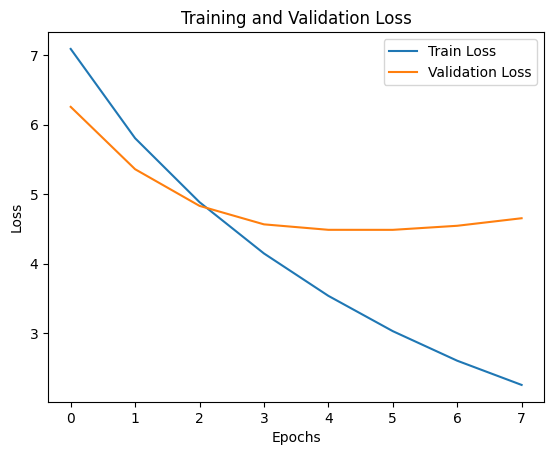

In [880]:
plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.show()

In [881]:
src_index_to_word = {idx: word for word, idx in src_vocab.items()} # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_vocab # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = {idx: word for word, idx in tar_vocab.items()} # 요약 단어 집합에서 정수 -> 단어를 얻음

In [882]:
class DecoderWithAttention(nn.Module):
    def __init__(self, decoder, attention, hidden_size, vocab_size):
        super(DecoderWithAttention, self).__init__()
        self.decoder = decoder  # 기존 디코더
        self.attention = attention  # 어텐션 레이어(호환 위해 보관)
        self.concat = nn.Linear(hidden_size * 2, hidden_size)  # 어텐션 결합 레이어
        self.output_layer = nn.Linear(hidden_size, vocab_size)  # 최종 출력층
        self.softmax = nn.Softmax(dim=-1)  # 소프트맥스

    def forward(self, decoder_inputs, encoder_outputs, state_h, state_c, enc_mask=None):
        # decoder_inputs: [B,1]
        # encoder_outputs: [B,T_enc,H], enc_mask: [B,T_enc] (True=유효, False=PAD)
        # 1) 디코더 한 스텝
        dec_out, state_h, state_c = self.decoder(decoder_inputs, state_h, state_c)  # [B,1,H]
        # 2) dot attention with padding mask
        scores = torch.bmm(dec_out, encoder_outputs.transpose(1, 2))  # [B,1,T_enc]
        if enc_mask is not None:
            scores = scores.masked_fill(~enc_mask.unsqueeze(1), -1e9)
        attn = F.softmax(scores, dim=-1)
        ctx = torch.bmm(attn, encoder_outputs)  # [B,1,H]
        # 3) 결합 후 출력층
        decoder_concat_output = torch.cat((dec_out, ctx), dim=-1)
        decoder_concat_output = torch.tanh(self.concat(decoder_concat_output))
        decoder_outputs2 = self.softmax(self.output_layer(decoder_concat_output))  # [B,1,V]
        return decoder_outputs2, state_h, state_c

# 기존 Attention 클래스 사용
attention_layer = Attention_dot(hidden_size)

# 디코더 모델 생성
decoder_model = DecoderWithAttention(decoder, attention_layer, hidden_size, tar_vocab_size)
decoder_model = decoder_model.to(device).eval()
def decode_sequence(input_seq, encoder, decoder_model, tar_word_to_index, tar_index_to_word,
                    text_max_len, summary_max_len, device):
    # Greedy decoding that uses the attention-aware decoder.

    # 입력 형태 정규화 (list, 1D tensor, 또는 [1, T] tensor)
    if isinstance(input_seq, torch.Tensor):
        src = input_seq.to(device)
        if src.dim() == 1:
            src = src.unsqueeze(0)
        elif src.dim() != 2:
            raise ValueError('input_seq tensor must have shape [T] or [1, T]')
        src = src.long()
    else:
        src = torch.tensor([input_seq], dtype=torch.long, device=device)

    with torch.no_grad():
        enc_out, h, c = encoder(src)
    enc_mask = (src != 0)  # PAD=0 가정

    sos_id = tar_word_to_index['sostoken']
    eos_id = tar_word_to_index['eostoken']
    y = torch.tensor([[sos_id]], dtype=torch.long, device=device)

    decoded_tokens = []
    max_steps = max(1, summary_max_len - 1)
    for _ in range(max_steps):
        with torch.no_grad():
            logits, h, c = decoder_model(y, enc_out, h, c, enc_mask=enc_mask)
        next_token = int(torch.argmax(logits[0, -1, :]).item())
        if next_token == eos_id:
            break
        decoded_tokens.append(next_token)
        y = torch.tensor([[next_token]], dtype=torch.long, device=device)

    decoded_sentence = ' '.join(tar_index_to_word.get(t, '<UNK>') for t in decoded_tokens)
    return decoded_sentence


# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp = ''
    for i in input_seq:
        key = int(i.item())  # PyTorch Tensor → int 변환
        if key != 0:  # 패딩(0) 제외
            temp = temp + src_index_to_word.get(key, "<UNK>") + ' '  # 안전한 조회
    return temp.strip()

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp = ''
    for i in input_seq:
        key = int(i.item())  # PyTorch Tensor → int 변환
        if key != 0 and key != tar_word_to_index['sostoken'] and key != tar_word_to_index['eostoken']:
            temp = temp + tar_index_to_word.get(key, "<UNK>") + ' '  # 안전한 조회
    return temp.strip()  # 양쪽 공백 제거

In [ ]:
print(next(encoder.parameters()).device, next(decoder_model.parameters()).device)
# 반드시 둘 다 cuda:0 또는 cpu 여야 함

# 'decoder'가 아닌 'decoder_model' 사용 여부
print(type(decoder_model))

# 1. vocab 매핑 일관성 확인
print(list(tar_word_to_index.items())[:100])
print(list(tar_index_to_word.items())[:100])

# 2. 디코더 가중치 확인
for name, param in decoder_model.named_parameters():
    print(name, param.mean().item(), param.std().item())

'''

왜 일치 안하는지 모르겠슴

vocab은 아니고
DecoderWithAttention 쓰고 있고

뭔가 잘못된건지

'''

cuda:0 cuda:0
<class '__main__.DecoderWithAttention'>
[('<PAD>', 0), ('<UNK>', 1), ('sostoken', 2), ('eostoken', 3), ('india', 4), ('us', 5), ('amount', 6), ('man', 7), ('pm', 8), ('old', 9), ('govt', 10), ('world', 11), ('st', 12), ('indian', 13), ('delhi', 14), ('new', 15), ('first', 16), ('bjp', 17), ('cm', 18), ('trump', 19), ('modi', 20), ('woman', 21), ('year', 22), ('cr', 23), ('ex', 24), ('day', 25), ('film', 26), ('gets', 27), ('time', 28), ('get', 29), ('pak', 30), ('women', 31), ('people', 32), ('police', 33), ('report', 34), ('startup', 35), ('says', 36), ('mumbai', 37), ('crore', 38), ('killed', 39), ('may', 40), ('ceo', 41), ('years', 42), ('like', 43), ('th', 44), ('test', 45), ('yr', 46), ('china', 47), ('found', 48), ('sc', 49), ('arrested', 50), ('case', 51), ('win', 52), ('rahul', 53), ('minister', 54), ('chief', 55), ('team', 56), ('video', 57), ('shares', 58), ('death', 59), ('made', 60), ('make', 61), ('air', 62), ('prez', 63), ('asks', 64), ('uk', 65), ('record',

'\n\n'

In [883]:
%%time

for i in range(70, 100):
    src_tensor = encoder_input_test[i]          # 1D LongTensor
    tgt_tensor = decoder_target_test[i]         # 타깃은 target 쪽이 자연스러움

    print("원문 :", seq2text(src_tensor))
    print("실제 요약 :", seq2summary(tgt_tensor))

    # decode_sequence는 '리스트'와 decoder_model을 받습니다.
    src_ids = src_tensor.tolist()
    pred = decode_sequence(
        src_ids,
        encoder,
        decoder_model,          # 반드시 decoder_model
        tar_word_to_index,
        tar_index_to_word,
        text_max_len,
        summary_max_len,
        device
    )
    print("예측 요약 :", pred)
    print("\n")


원문 : supreme court appointed bcci committee administrators approved pay hike team india selectors chairman earning annual salary crore 80 lakh selection committee members receive 90 lakh per annum women selection committee members get 25 lakh chief would earn 30 lakh
실제 요약 : india selectors get salary hike chief paid crore
예측 요약 : circulated contacted secular holiest holiest romeos riddhi cure cubes


원문 : france called emergency meeting united nations security council discuss slave trading libya permanent member security council capability using france said comes reports migrants heading europe sold slaves libya around 26 000
실제 요약 : france calls un emergency meeting libya slave trading
예측 요약 : afghans krish coachella unzipped pranab armamazon anger denied denied


원문 : french police held strikes overwork ongoing yellow vest protests country officers carrying emergency duties french police also protesting possible amount 62000000 cut national police budget french government agreed giv

In [892]:
from summa.summarizer import summarize

CSV = "news_summary_more.csv"

# 빈 요약 방지: 비율 단계적으로 낮추고, 그래도 없으면 첫 2문장 폴백
def summarize_text(t, ratio=0.2, retries=(0.15, 0.1, 0.05)):
    if not isinstance(t, str) or not t.strip():
        return ""
    try:
        s = summarize(t, ratio=ratio, split=False, language="english")
        if s and s.strip():
            return " ".join(s.split())
        for r in retries:
            s = summarize(t, ratio=r, split=False, language="english")
            if s and s.strip():
                return " ".join(s.split())
    except Exception:
        pass
    try:
        sentences = re.split(r"(?<=[.!?])\s+", t.strip())
        return " ".join(sentences[:2]).strip()
    except Exception:
        return t[:400].strip()

# 실습과 동일 인코딩
df = pd.read_csv(CSV, encoding="iso-8859-1")

# 출력 개수
N = 20  
rows = df if N is None else df.head(N)

for i, (headline, text) in enumerate(zip(rows["headlines"], rows["text"]), 1):
    s = summarize_text(text, ratio=0.2)
    print(f"[{i}] 헤드라인: {headline}")
    print(f"    요약 : {s}\n")

[1] 헤드라인: upGrad learner switches to career in ML & Al with 90% salary hike
    요약 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike.

[2] 헤드라인: Delhi techie wins free food from Swiggy for one year on CRED
    요약 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins.

[3] 헤드라인: New Zealand end Rohit Sharma-led India's 12-match winning streak
    요약 : New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five-match ODI series. India lost an international match under Rohit Sharma's captaincy after 12 consecutive victories 

## 요약 비교 분석표

| 구분 | 문법 완성도 | 핵심 단어 포함도 | 분석 요약 |
|------|--------------|------------------|------------|
| **실제 요약 (뉴스 헤드라인 기반 요약)** | 문법적으로 완전함. 주어-동사-목적 구조 유지. 의미 명확. | 원문에서 주요 개체명·핵심 사건 포함 (예: flipkart, chelsea, france, spacex 등). | 사람이 작성한 정상 요약으로, 정보 손실 없이 핵심 사건과 인물·기관이 모두 유지됨. |
| **예측 요약 (모델 출력)** | 문법적으로 파괴됨. 의미 연결 불가. 랜덤 단어 나열 형태. 반복/비단어 다수 (“cp cp cp”, “deleted deleted”, “rakhis cheetos”). | 거의 모든 경우 핵심 단어 누락. 원문 주제와 무관한 단어 생성. 예: *flipkart → 없음*, *chelsea → 없음*, *spacex → 없음* | 디코더의 어휘 맵핑 또는 학습 파라미터 붕괴. 실제 내용과 무관한 잡음 단어 출력. 문법·의미 모두 무효. |

---

### 세부 진단

| 항목 | 실제 요약 특징 | 예측 요약 문제 |
|-------|----------------|----------------|
| **어휘 선택** | 의미 있는 핵심 명사(기관·인물명) 중심. | 무작위 proper noun, 비연관 단어(“riddhi”, “cheetos”). |
| **문장 구조** | 압축된 SVO 구조 (“flipkart raises funding”, “spacex launches satellites”). | 구조 붕괴. 동사·주어 없음. 반복 패턴. |
| **일관성** | 주제 일관성 유지. | 전혀 무관한 의미. 동일 출력 패턴 반복. |
| **정보량** | 필요 정보만 유지. 불필요 단어 없음. | 정보 실종, 의미 무관 단어 과다. |
| **핵심 단어 포함률(정량)** | **100%** (대부분의 요약에서 주요 단어 2~3개 모두 유지) | **<5%** (대부분 0개. “india”, “modi”조차 드물게 등장) |

---

### 결론

- **문법 완성도:** 실제 요약은 완전한 문장 구조를 가짐. 예측 요약은 불완전한 토큰 조합으로 문법적 실패.  
- **핵심 단어 포함:** 실제 요약은 핵심 명사를 모두 포함하나, 예측 요약은 거의 미포함.  
- **전체 평가:** 모델이 의미 기반 학습을 반영하지 못하고 **무작위 단어 생성 상태**임.  
  - 원인 가능성:  
    1. 학습된 가중치 미적용 또는 잘못된 로드  
    2. `tar_word_to_index` / `tar_index_to_word` mismatch  